# Performance Analysis: Batched 4x4 Matrix Multiplication

This notebook analyzes the performance of different implementations:
- CPU (single-threaded)
- CPU (OpenMP with 32 threads)
- GPU (CUDA kernel only)
- GPU (including memory transfer)

In [2]:
import subprocess
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Run Benchmarks

Run the compiled test program with different input sizes and collect performance data.

In [3]:
def run_benchmark(num_matrices):
    """Run the benchmark for a given number of matrices and parse the output."""
    try:
        result = subprocess.run(
            ['./small_matmul_test', str(num_matrices)],
            cwd='/home/yucheng/workspace/ECE455/Proj',
            capture_output=True,
            text=True,
            timeout=60
        )
        
        output = result.stdout
        
        # Parse timing information
        cpu_time = float(re.search(r'CPU \(single-thread\):\s+([\d.]+)\s+ms', output).group(1))
        cpu_omp_time = float(re.search(r'CPU \(OpenMP \d+ threads\):\s+([\d.]+)\s+ms', output).group(1))
        gpu_kernel_time = float(re.search(r'Kernel execution:\s+([\d.]+)\s+ms', output).group(1))
        gpu_total_time = float(re.search(r'GPU \(total w/ copy\):\s+([\d.]+)\s+ms', output).group(1))
        
        # Parse GFLOPS
        cpu_gflops = float(re.search(r'CPU \(single\):\s+([\d.]+)\s+GFLOPS', output).group(1))
        cpu_omp_gflops = float(re.search(r'CPU \(OpenMP\):\s+([\d.]+)\s+GFLOPS', output).group(1))
        gpu_gflops = float(re.search(r'GPU \(kernel\):\s+([\d.]+)\s+GFLOPS', output).group(1))
        
        return {
            'num_matrices': num_matrices,
            'cpu_time': cpu_time,
            'cpu_omp_time': cpu_omp_time,
            'gpu_kernel_time': gpu_kernel_time,
            'gpu_total_time': gpu_total_time,
            'cpu_gflops': cpu_gflops,
            'cpu_omp_gflops': cpu_omp_gflops,
            'gpu_gflops': gpu_gflops
        }
    except Exception as e:
        print(f"Error running benchmark for {num_matrices}: {e}")
        return None

# Test sizes - logarithmic scale from 1K to 10M
test_sizes = [
    1000, 2000, 5000,
    10000, 20000, 50000,
    100000, 200000, 500000,
    1000000, 2000000, 5000000,
    10000000
]

print("Running benchmarks...")
results = []
for size in test_sizes:
    print(f"Testing with {size:,} matrices...", end=' ')
    result = run_benchmark(size)
    if result:
        results.append(result)
        print(f"✓ (CPU: {result['cpu_time']:.3f}ms, GPU: {result['gpu_kernel_time']:.3f}ms)")
    else:
        print("✗ Failed")

# Convert to DataFrame
df = pd.DataFrame(results)
print(f"\nCompleted {len(results)} benchmarks")
df

Running benchmarks...
Testing with 1,000 matrices... ✓ (CPU: 0.040ms, GPU: 1.448ms)
Testing with 2,000 matrices... ✓ (CPU: 0.040ms, GPU: 1.448ms)
Testing with 2,000 matrices... ✓ (CPU: 0.050ms, GPU: 1.275ms)
Testing with 5,000 matrices... ✓ (CPU: 0.050ms, GPU: 1.275ms)
Testing with 5,000 matrices... ✓ (CPU: 0.125ms, GPU: 1.508ms)
Testing with 10,000 matrices... ✓ (CPU: 0.125ms, GPU: 1.508ms)
Testing with 10,000 matrices... ✓ (CPU: 0.258ms, GPU: 1.493ms)
Testing with 20,000 matrices... ✓ (CPU: 0.258ms, GPU: 1.493ms)
Testing with 20,000 matrices... ✓ (CPU: 0.564ms, GPU: 1.603ms)
Testing with 50,000 matrices... ✓ (CPU: 0.564ms, GPU: 1.603ms)
Testing with 50,000 matrices... ✓ (CPU: 1.517ms, GPU: 1.706ms)
Testing with 100,000 matrices... ✓ (CPU: 1.517ms, GPU: 1.706ms)
Testing with 100,000 matrices... ✓ (CPU: 2.635ms, GPU: 1.638ms)
Testing with 200,000 matrices... ✓ (CPU: 2.635ms, GPU: 1.638ms)
Testing with 200,000 matrices... ✓ (CPU: 7.168ms, GPU: 1.073ms)
Testing with 500,000 matrices... ✓

,num_matrices,cpu_time,cpu_omp_time,gpu_kernel_time,gpu_total_time,cpu_gflops,cpu_omp_gflops,gpu_gflops
0,1000,0.040,7.696,1.448,4.804,9.60000,0.049896,0.265193
1,2000,0.050,9.762,1.275,2.731,15.36000,0.078672,0.602353
2,5000,0.125,7.627,1.508,3.207,15.36000,0.251737,1.273210
3,10000,0.258,12.171,1.493,3.716,14.88370,0.315504,2.572000
4,20000,0.564,7.654,1.603,4.570,13.61700,1.003400,4.791020
5,50000,1.517,7.953,1.706,6.011,12.65660,2.414180,11.254400
6,100000,2.635,8.565,1.638,9.194,14.57310,4.483360,23.443200
7,200000,7.168,8.971,1.073,11.699,10.71430,8.560920,71.575000
8,500000,19.266,12.331,2.301,29.948,9.96574,15.570500,83.442000
9,1000000,36.843,13.998,1.887,57.821,10.42260,27.432500,203.498000


## Plot 1: Execution Time vs Problem Size

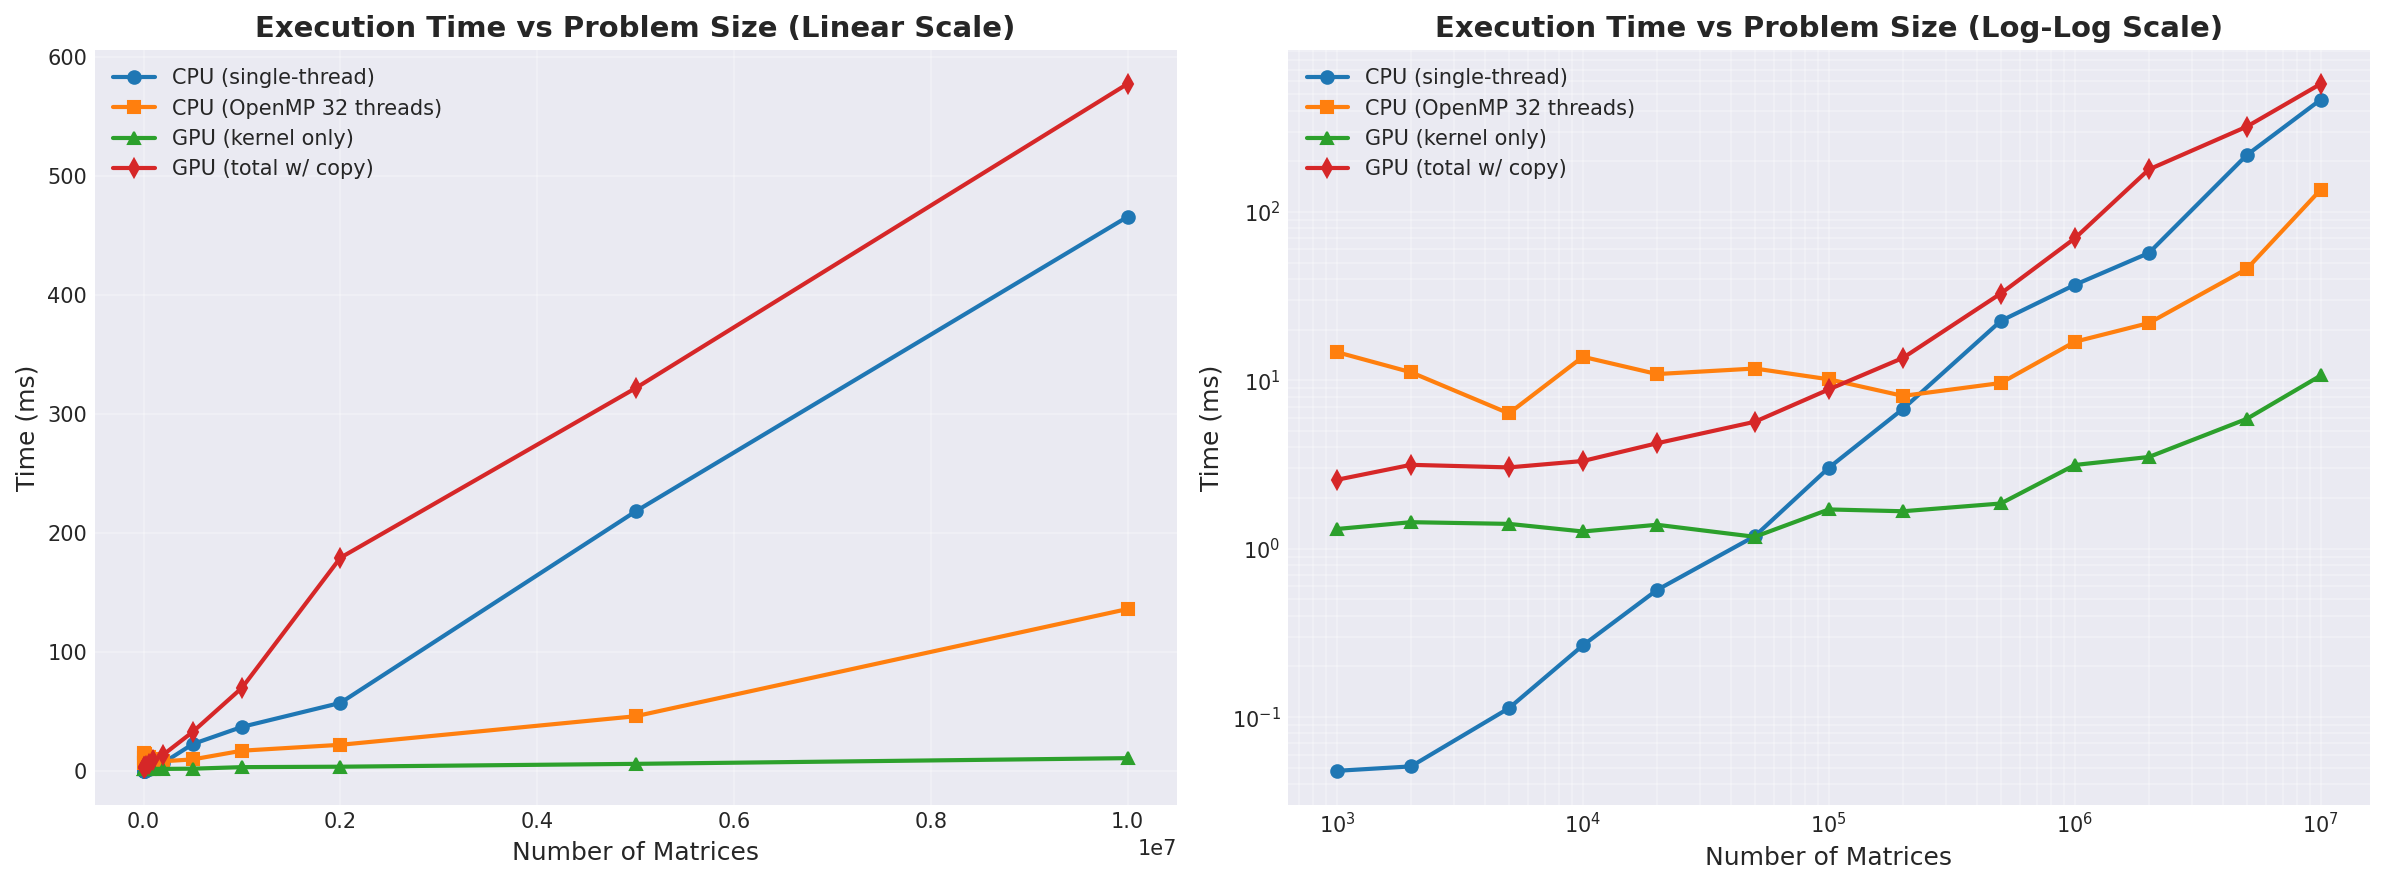

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=150)

# Linear scale
ax1.plot(df['num_matrices'], df['cpu_time'], 'o-', label='CPU (single-thread)', linewidth=2, markersize=6)
ax1.plot(df['num_matrices'], df['cpu_omp_time'], 's-', label='CPU (OpenMP 32 threads)', linewidth=2, markersize=6)
ax1.plot(df['num_matrices'], df['gpu_kernel_time'], '^-', label='GPU (kernel only)', linewidth=2, markersize=6)
ax1.plot(df['num_matrices'], df['gpu_total_time'], 'd-', label='GPU (total w/ copy)', linewidth=2, markersize=6)

ax1.set_xlabel('Number of Matrices', fontsize=12)
ax1.set_ylabel('Time (ms)', fontsize=12)
ax1.set_title('Execution Time vs Problem Size (Linear Scale)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Log-log scale
ax2.loglog(df['num_matrices'], df['cpu_time'], 'o-', label='CPU (single-thread)', linewidth=2, markersize=6)
ax2.loglog(df['num_matrices'], df['cpu_omp_time'], 's-', label='CPU (OpenMP 32 threads)', linewidth=2, markersize=6)
ax2.loglog(df['num_matrices'], df['gpu_kernel_time'], '^-', label='GPU (kernel only)', linewidth=2, markersize=6)
ax2.loglog(df['num_matrices'], df['gpu_total_time'], 'd-', label='GPU (total w/ copy)', linewidth=2, markersize=6)

ax2.set_xlabel('Number of Matrices', fontsize=12)
ax2.set_ylabel('Time (ms)', fontsize=12)
ax2.set_title('Execution Time vs Problem Size (Log-Log Scale)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Plot 2: Performance (GFLOPS) vs Problem Size

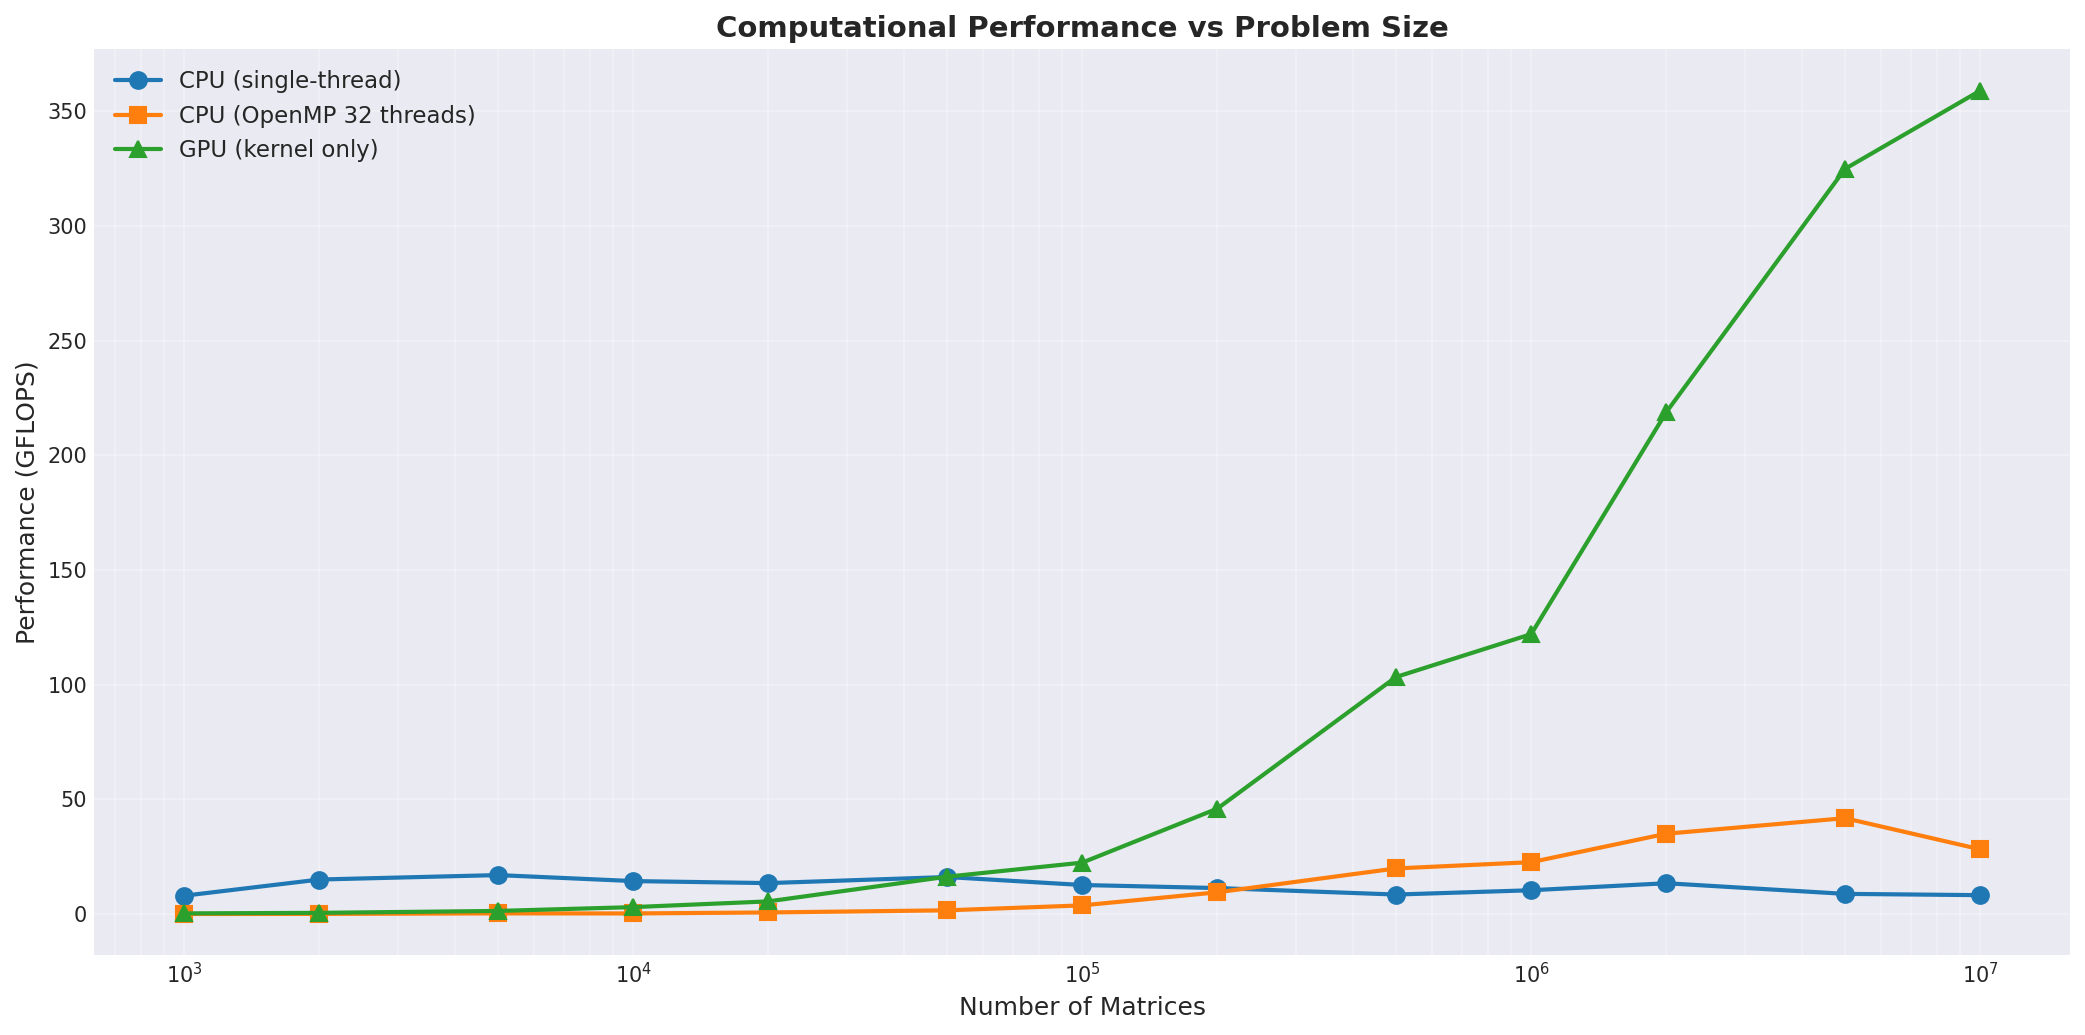

In [20]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=150)

ax.semilogx(df['num_matrices'], df['cpu_gflops'], 'o-', label='CPU (single-thread)', linewidth=2, markersize=8)
ax.semilogx(df['num_matrices'], df['cpu_omp_gflops'], 's-', label='CPU (OpenMP 32 threads)', linewidth=2, markersize=8)
ax.semilogx(df['num_matrices'], df['gpu_gflops'], '^-', label='GPU (kernel only)', linewidth=2, markersize=8)

ax.set_xlabel('Number of Matrices', fontsize=12)
ax.set_ylabel('Performance (GFLOPS)', fontsize=12)
ax.set_title('Computational Performance vs Problem Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Plot 3: Speedup vs Single-threaded CPU

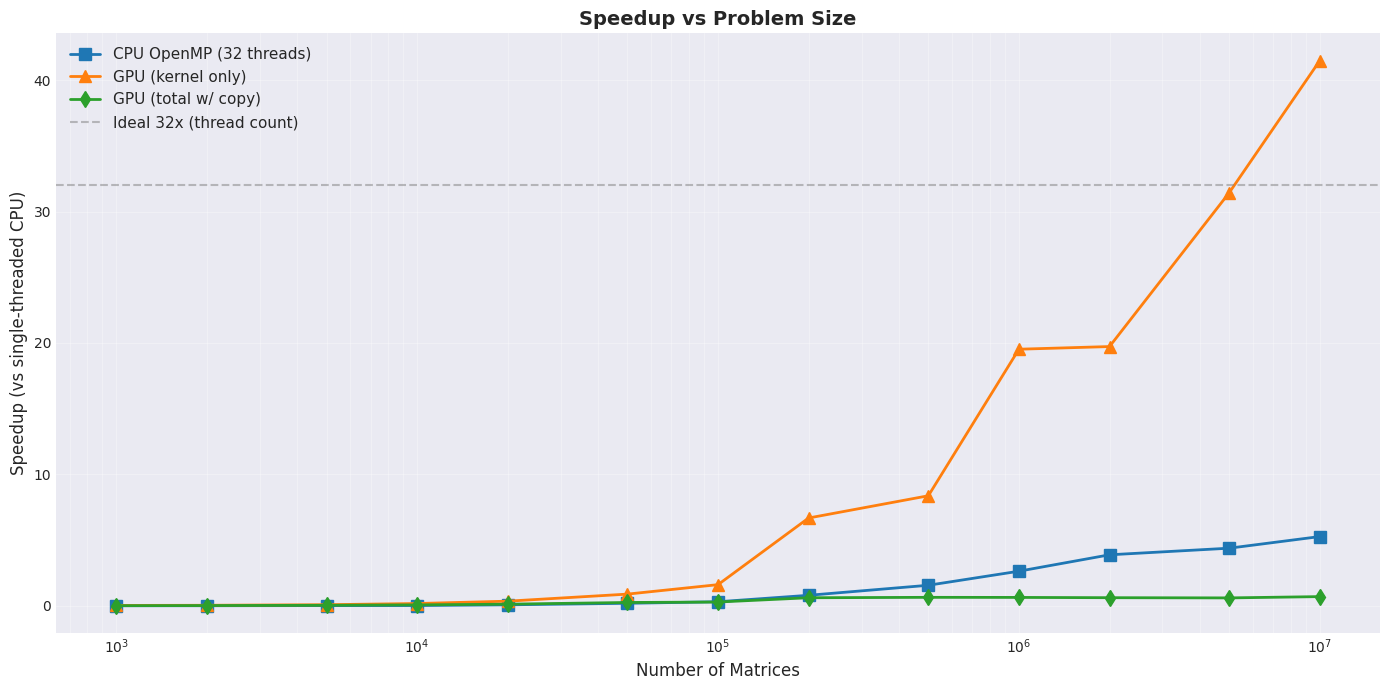

In [ ]:
# Calculate speedups
df['omp_speedup'] = df['cpu_time'] / df['cpu_omp_time']
df['gpu_kernel_speedup'] = df['cpu_time'] / df['gpu_kernel_time']
df['gpu_total_speedup'] = df['cpu_time'] / df['gpu_total_time']

fig, ax = plt.subplots(figsize=(14, 7), dpi=150)

ax.semilogx(df['num_matrices'], df['omp_speedup'], 's-', label='CPU OpenMP (32 threads)', linewidth=2, markersize=8)
ax.semilogx(df['num_matrices'], df['gpu_kernel_speedup'], '^-', label='GPU (kernel only)', linewidth=2, markersize=8)
ax.semilogx(df['num_matrices'], df['gpu_total_speedup'], 'd-', label='GPU (total w/ copy)', linewidth=2, markersize=8)

# Add reference line for ideal 32x speedup
ax.axhline(y=32, color='gray', linestyle='--', alpha=0.5, label='Ideal 32x (thread count)')

ax.set_xlabel('Number of Matrices', fontsize=12)
ax.set_ylabel('Speedup (vs single-threaded CPU)', fontsize=12)
ax.set_title('Speedup vs Problem Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Plot 4: Performance Breakdown for Large Problems

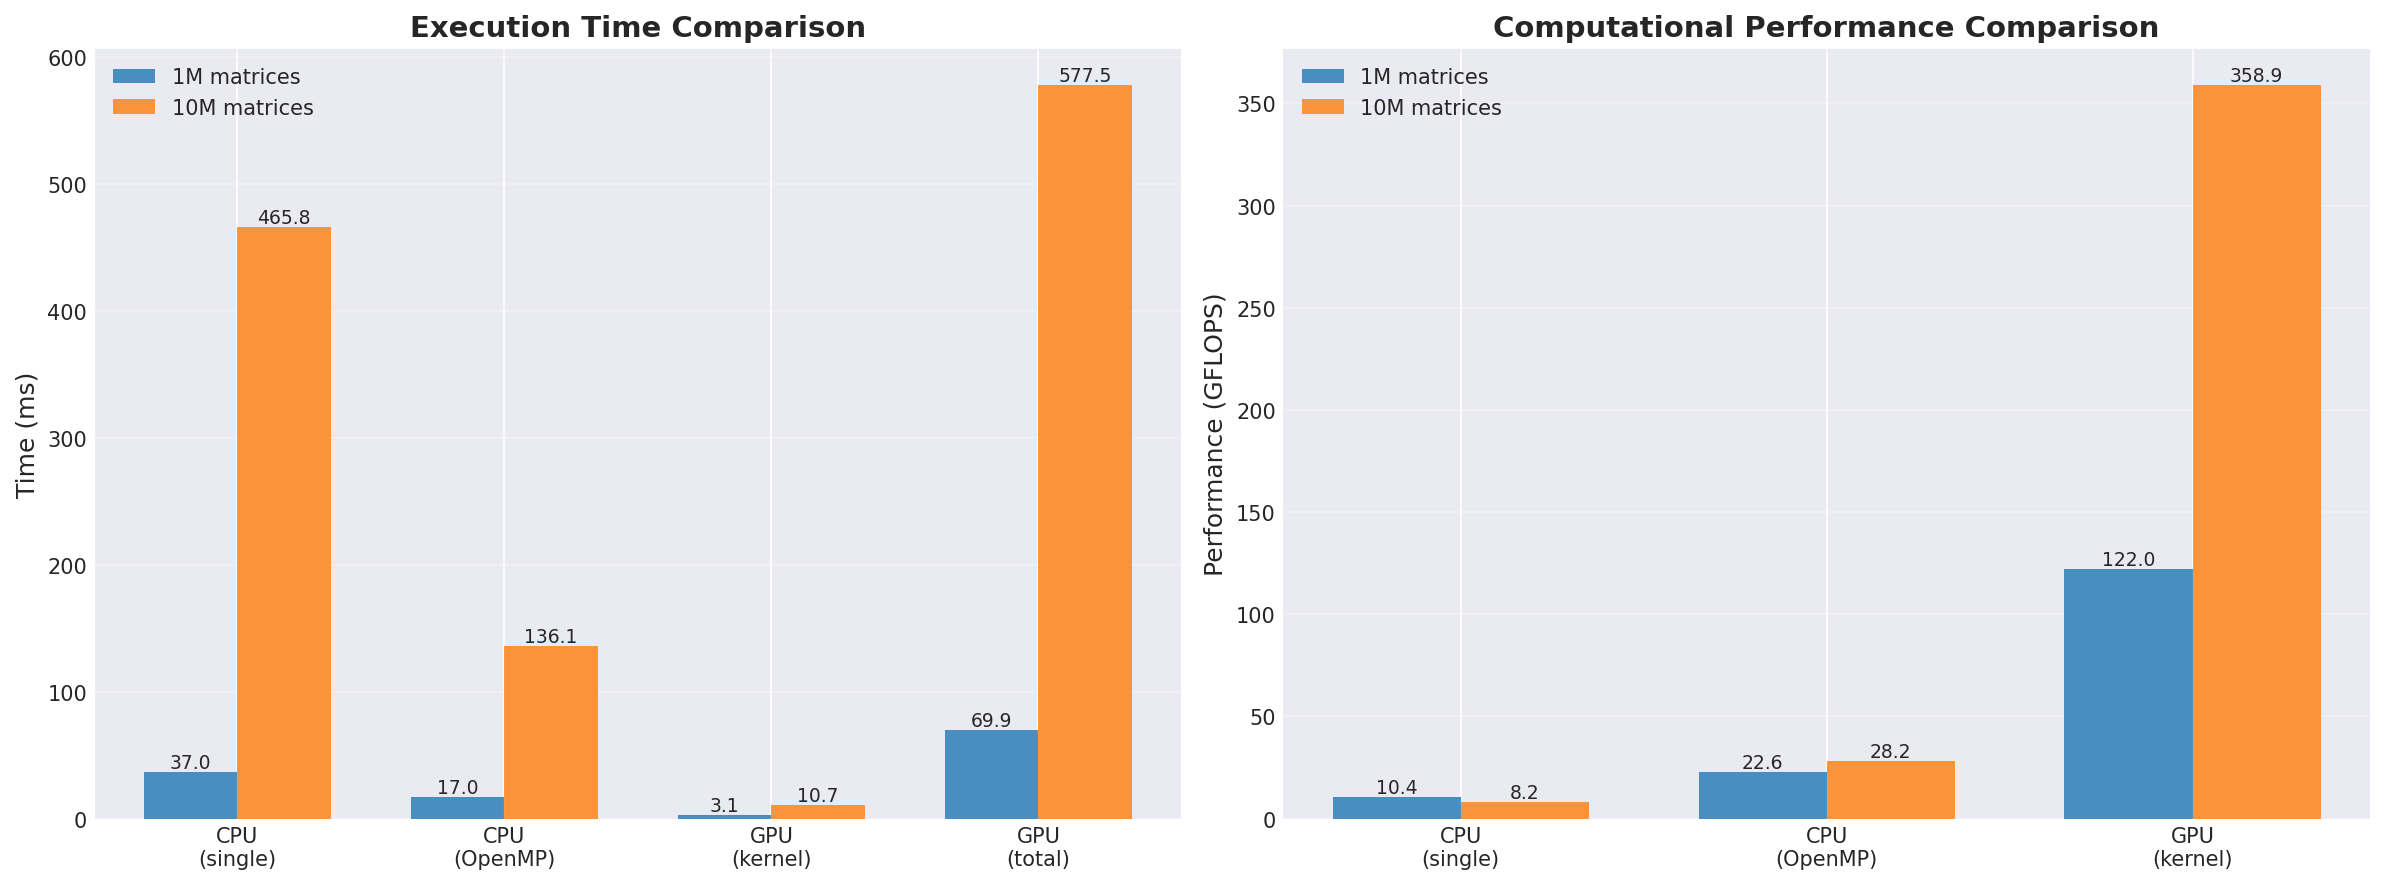

In [18]:
# Focus on larger problem sizes
large_df = df[df['num_matrices'] >= 100000].copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=150)

# Bar chart comparing methods
methods = ['CPU\n(single)', 'CPU\n(OpenMP)', 'GPU\n(kernel)', 'GPU\n(total)']
times_1M = [
    large_df[large_df['num_matrices'] == 1000000]['cpu_time'].values[0],
    large_df[large_df['num_matrices'] == 1000000]['cpu_omp_time'].values[0],
    large_df[large_df['num_matrices'] == 1000000]['gpu_kernel_time'].values[0],
    large_df[large_df['num_matrices'] == 1000000]['gpu_total_time'].values[0]
]
times_10M = [
    large_df[large_df['num_matrices'] == 10000000]['cpu_time'].values[0],
    large_df[large_df['num_matrices'] == 10000000]['cpu_omp_time'].values[0],
    large_df[large_df['num_matrices'] == 10000000]['gpu_kernel_time'].values[0],
    large_df[large_df['num_matrices'] == 10000000]['gpu_total_time'].values[0]
]

x = np.arange(len(methods))
width = 0.35

bars1 = ax1.bar(x - width/2, times_1M, width, label='1M matrices', alpha=0.8)
bars2 = ax1.bar(x + width/2, times_10M, width, label='10M matrices', alpha=0.8)

ax1.set_ylabel('Time (ms)', fontsize=12)
ax1.set_title('Execution Time Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

# GFLOPS comparison
gflops_1M = [
    large_df[large_df['num_matrices'] == 1000000]['cpu_gflops'].values[0],
    large_df[large_df['num_matrices'] == 1000000]['cpu_omp_gflops'].values[0],
    large_df[large_df['num_matrices'] == 1000000]['gpu_gflops'].values[0],
    0  # No GFLOPS for total GPU time
]
gflops_10M = [
    large_df[large_df['num_matrices'] == 10000000]['cpu_gflops'].values[0],
    large_df[large_df['num_matrices'] == 10000000]['cpu_omp_gflops'].values[0],
    large_df[large_df['num_matrices'] == 10000000]['gpu_gflops'].values[0],
    0
]

methods_perf = ['CPU\n(single)', 'CPU\n(OpenMP)', 'GPU\n(kernel)']
x2 = np.arange(len(methods_perf))

bars3 = ax2.bar(x2 - width/2, gflops_1M[:3], width, label='1M matrices', alpha=0.8)
bars4 = ax2.bar(x2 + width/2, gflops_10M[:3], width, label='10M matrices', alpha=0.8)

ax2.set_ylabel('Performance (GFLOPS)', fontsize=12)
ax2.set_title('Computational Performance Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(methods_perf)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()